In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle

from casadi import *

import keras2casadi

In [2]:
%matplotlib notebook

# Load Model

In [3]:
model_name = '002'

model = tf.keras.models.load_model('./keras_models/{name}/{name}_model/'.format(name=model_name))

with open('./keras_models/{}/scaling.pkl'.format(model_name), 'rb') as f:
    scaling = pickle.load(f)

input_scaling = scaling['input']
output_scaling = scaling['output']

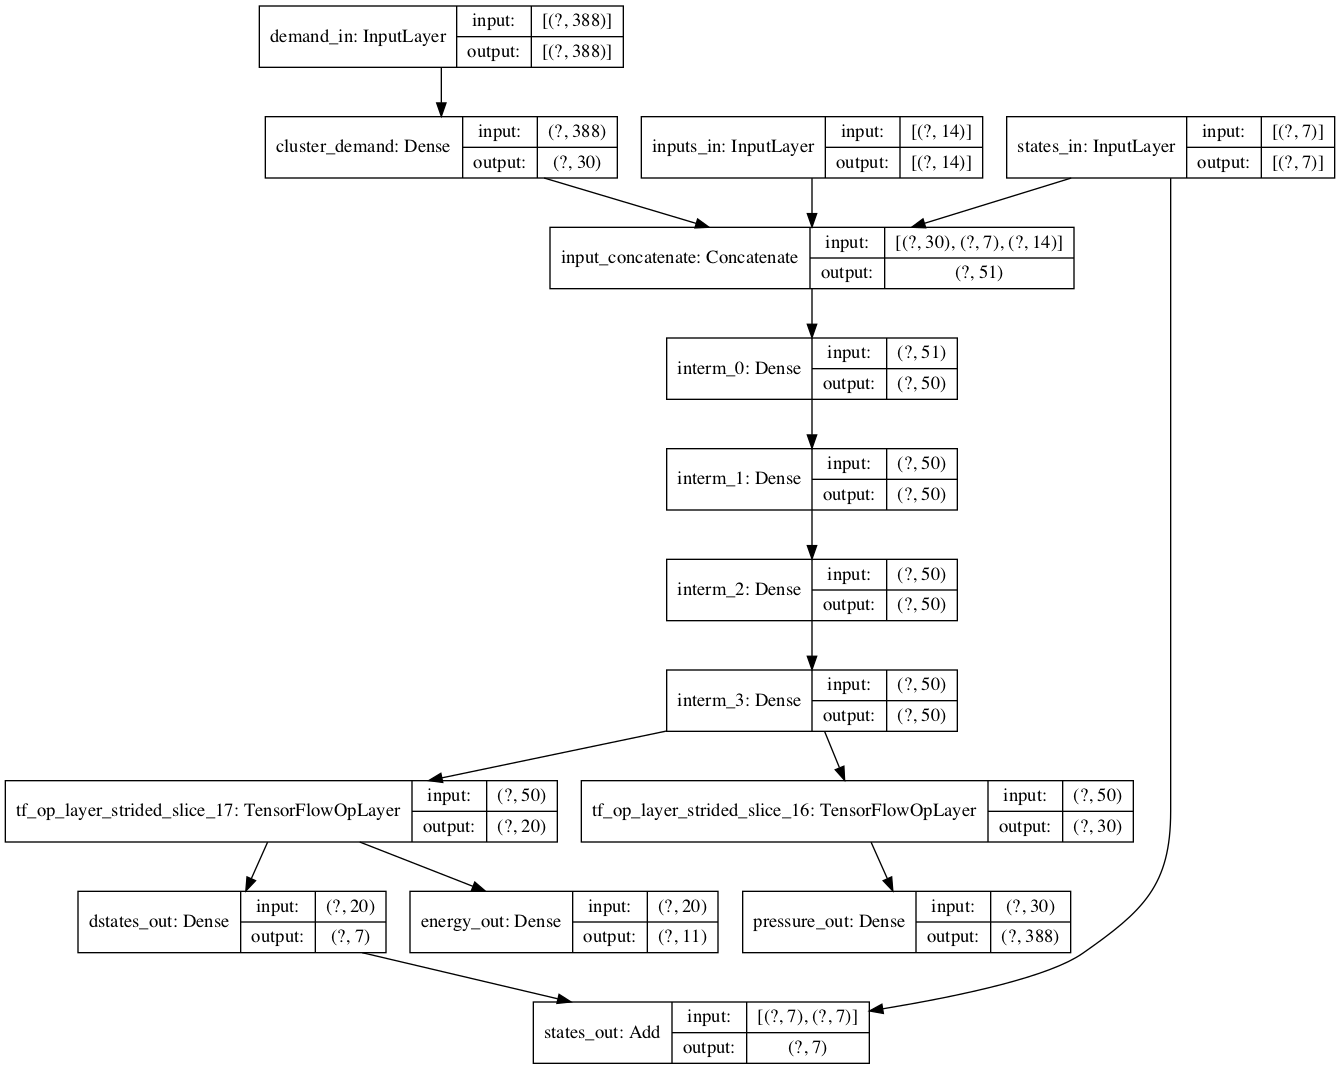

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [5]:
def eval_nn(model, layer_out):
    config = model.get_config()

    # For each layer in the layers list:
    for layer_k in config['layers']:
        # If the output of a given layer is already in the inputs, skip this layer.
        if layer_k['name'] in layer_out.keys():
            pass
        
        # Type: InputLayer
        elif layer_k['class_name'] == 'InputLayer':
            pass

        # Type: Dense layer
        elif layer_k['class_name'] == 'Dense':
            weights = model.get_layer(layer_k['name']).get_weights()
            
            name_in = layer_k['inbound_nodes'][0][0][0]
            tensor_in = layer_out[name_in]

            tensor_out = tensor_in@weights[0] 
            if layer_k['config']['use_bias']:
                tensor_out = tensor_out + weights[1].reshape(1,-1)

            if layer_k['config']['activation'] == 'tanh':
                tensor_out = np.tanh(tensor_out)
            elif layer_k['config']['activation'] == 'relu':
                tensor_out = np.maximum(tensor_out,0)
            elif layer_k['config']['activation'] == 'linear':
                pass
            else:
                raise Exception('Unknown activation.')


            layer_out[layer_k['name']] = tensor_out

        # Type: Concatenate layer
        elif layer_k['class_name'] == 'Concatenate':
            concatenate_list = []
            sym_type_list = []
            for input_j in layer_k['inbound_nodes'][0]:
                tensor_in = layer_out[input_j[0]]
                concatenate_list.append(tensor_in)
                sym_type_list.append(isinstance(tensor_in, (casadi.MX, casadi.SX, casadi.DM)))
                  
            if any(sym_type_list):
                tensor_out = horzcat(*concatenate_list)
            else:     
                tensor_out = np.concatenate(concatenate_list, axis=1)
            layer_out[layer_k['name']] = tensor_out

        # Type: Slicing layer
        elif layer_k['class_name'] == 'TensorFlowOpLayer':
            # Get slicing indices (stored in constants)
            start = layer_k['config']['constants'][1]
            stop = layer_k['config']['constants'][2]
            step = layer_k['config']['constants'][3]

            # Prepare slicing objects and store them in a list:
            slice_list = []
            for start_i, step_i, stop_i in zip(start,step,stop):
                # Slicing is coded: 0 means None
                if start_i == 0: start_i = None
                if step_i == 0: step_i = None
                if stop_i == 0: stop_i = None
                slice_list.append(slice(start_i, stop_i, step_i))

            slice_tuple = tuple(slice_list)

            # Get and slice inbound node:
            name_in = layer_k['inbound_nodes'][0][0][0]
            tensor_in = layer_out[name_in]
            tensor_out = tensor_in[slice_tuple]

            layer_out[layer_k['name']] = tensor_out

        elif layer_k['class_name'] =='Add':
            # Add layer:
            tensor_out = 0
            for name_in in layer_k['inbound_nodes'][0]:
                tensor_in = layer_out[name_in[0]]
                tensor_out += tensor_in

            layer_out[layer_k['name']] = tensor_out

        else:
            raise Exception('Unsupported layer of type {}'.format(layer_k['class_name']))
            
    return layer_out




Evaluate and compare numpy vs keras:

In [6]:
inputs = {
    'demand_in' : np.ones((1,388)),
    'states_in' : np.ones((1,7)),
    'inputs_in' : np.ones((1,14))
}

weights, config = model.get_weights(), model.get_config()


layer_out_num = eval_nn(model, inputs)

keras_pred = model.predict([
    inputs['demand_in'], 
    inputs['states_in'], 
    inputs['inputs_in']
])

In [7]:
layer_out_num['states_out']

array([[1.088, 0.98 , 0.864, 1.051, 1.115, 0.958, 1.072]])

In [8]:
keras_pred[2]

array([[1.088, 0.98 , 0.864, 1.051, 1.115, 0.958, 1.072]], dtype=float32)

Evaluate with CasADi, make function:

In [13]:
inputs_sym = {
    'demand_in': MX.sym('demand_in', 1,388),
    'states_in': MX.sym('states_in', 1,7),
    'inputs_in': MX.sym('inputs_in', 1,14)
}


layer_out_sym = keras2casadi.eval_nn(model, inputs_sym)

nn_cas_fun = Function(
    'nn_cas_fun',
    [
    inputs_sym['demand_in'], 
    inputs_sym['states_in'], 
    inputs_sym['inputs_in']], 
    [layer_out_sym['pressure_out'],
    layer_out_sym['energy_out'],
    layer_out_sym['states_out']]
)

Evaluate CasADi function and compare with keras:

In [14]:
casadi_pred = nn_cas_fun(
    inputs['demand_in'], 
    inputs['states_in'], 
    inputs['inputs_in']    
)
np.round(casadi_pred[2],3)

array([[1.088, 0.98 , 0.864, 1.051, 1.115, 0.958, 1.072]])

The network can also be evaluated started from inner layers:

In [11]:
inputs_sym = {
    'cluster_demand': MX.sym('demand_in', 1,30),
    'states_in': MX.sym('states_in', 1,7),
    'inputs_in': MX.sym('inputs_in', 1,14)
}


layer_out_sym_02 = eval_nn(model, inputs_sym)

nn_cas_fun_02 = Function(
    'nn_cas_fun',
    [
    inputs_sym['cluster_demand'], 
    inputs_sym['states_in'], 
    inputs_sym['inputs_in']], 
    [layer_out_sym_02['tf_op_layer_strided_slice_16'],
    layer_out_sym_02['energy_out'],
    layer_out_sym_02['states_out']]
)

Evaluate with precomputed cluster_demand from numerical evaluation:

In [12]:
casadi_pred_02 = nn_cas_fun_02(
    layer_out_num['cluster_demand'], 
    inputs['states_in'], 
    inputs['inputs_in']    
)
np.round(casadi_pred_02[2],3)

array([[1.088, 0.98 , 0.864, 1.051, 1.115, 0.958, 1.072]])